We used KaggleHub to download the Conjunctivitis Dataset from Kaggle. After
 downloading, we printed the dataset path to confirm that it was stored correctly.
 This dataset includes images of both healthy and infected eyes. We explored the
 folders to make sure the data was organized and ready for processing. We
 imported straight from Kaggle using the API and used 2 test images for the
 dataset.

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("alisofiya/conjunctivitis")
print("Path to dataset files:", path)

**Step 1** Install Packages and Imports

In [ ]:
# Cell 1 — install & imports
# -------------------------------------------------
# Install required packages (quiet mode, safe if already installed)
!pip install -q kagglehub tensorflow matplotlib scikit-learn pandas pillow

# -------------------------------------------------
# Core imports
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------------------------
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

**Step 2 Ensure dataset path is available**

This cell checks whether the path exist and downloads if needed. It then finds image files recursively under that path and infers labels from parent folders

In [ ]:
# Cell 2 — locate / download dataset and build a DataFrame (image_path, label)
from pathlib import Path
import pandas as pd
import kagglehub

# -------------------------------------------------
# Try to reuse a previously-downloaded path; otherwise download
try:
    path                     # <-- just check if the variable exists
    print("Using existing `path` variable:", path)
except NameError:
    print("`path` not found — downloading dataset via kagglehub...")
    path = kagglehub.dataset_download("alisofiya/conjunctivitis")
    print("Downloaded dataset to:", path)

# -------------------------------------------------
# Convert to Path object
dataset_root = Path(path)

# -------------------------------------------------
# Find **all** image files (jpg + jpeg + png – the dataset contains a few .png)
img_files = (
    list(dataset_root.rglob("*.jpg")) +
    list(dataset_root.rglob("*.jpeg")) +
    list(dataset_root.rglob("*.png"))) # Corrected variable name here

**Step 3 Quick EDA:**

Class counts and sample images shows how many images per class and some example images.

In [ ]:
# Cell 3 — EDA: class distribution + sample images

# Create DataFrame from img_files
rows = [[str(p), p.parent.name] for p in img_files]
df = pd.DataFrame(rows, columns=["image_path", "label"])
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

counts = df['label'].value_counts()
print("Class distribution:\n", counts)
# bar plot
plt.figure(figsize=(5,4))
counts.plot(kind='bar')
plt.title("Class distribution")
plt.ylabel("Count")
plt.show()
# show up to 6 sample images (1 per class if multiple)
plt.figure(figsize=(12,4))
unique_labels = df['label'].unique()
for i, lab in enumerate(unique_labels[:6]):
    sample = df[df['label']==lab].iloc[0]['image_path']
    img = Image.open(sample).convert('RGB')
    plt.subplot(1, min(6, len(unique_labels)), i+1)
    plt.imshow(img.resize((200,200)))
    plt.title(lab)
    plt.axis('off')
plt.show()

**Step 4 Split into train /val/ test (80/10/10)**
We create splits keeping class balance (stratify)

In [ ]:
# Cell 4 — train/val/test split
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)
print("Counts -> Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

**Step 5**

Create ImageDataGenerators (with simple augmentation for train)

We use flow_from_dataframe with directory=None and x_col containing full paths.class_mode='binary' if there are exactly 2 labels; otherwise 'categorical' for multi-class. The code auto-detects whether binary or multi-class.

In [ ]:
# Cell 5 — prepare generators
IMG_SIZE = (128, 128) # small for fast prototyping
BATCH_SIZE = 16
# determine if binary
unique_labels = sorted(df['label'].unique())
is_binary = (len(unique_labels) == 2)
print("Binary classification?" , is_binary, "Labels:", unique_labels)
# training augmentation
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=10,
width_shift_range=0.05,
height_shift_range=0.05,
zoom_range=0.05,
horizontal_flip=True
)
# validation & test just rescale
test_val_datagen = ImageDataGenerator(rescale=1./255)
# flow_from_dataframe expects column names and directory argument. If x_col has full paths use directory=None
if is_binary:
    class_mode = 'binary'
else:
    class_mode = 'categorical'

# Convert image_path column to string type
train_df['image_path'] = train_df['image_path'].astype(str)
val_df['image_path'] = val_df['image_path'].astype(str)
test_df['image_path'] = test_df['image_path'].astype(str)

train_gen = train_datagen.flow_from_dataframe(
train_df,
x_col='image_path',
y_col='label',
target_size=IMG_SIZE,
batch_size=BATCH_SIZE,
class_mode=class_mode,
shuffle=True,
directory=None
)
val_gen = test_val_datagen.flow_from_dataframe(
val_df,
x_col='image_path',
y_col='label',
target_size=IMG_SIZE,
batch_size=BATCH_SIZE,
class_mode=class_mode,
shuffle=False,
directory=None
)
test_gen = test_val_datagen.flow_from_dataframe(
test_df,
x_col='image_path',
y_col='label',
target_size=IMG_SIZE,
batch_size=BATCH_SIZE,
class_mode=class_mode,
shuffle=False,
directory=None
)
label2index = train_gen.class_indices
index2label = {v:k for k,v in label2index.items()}
print("Label mapping (label -> index):", label2index)

**Step 6**

Build a small CNN (fast to run)
A compact architecture suitable for 5 epochs prototype. We ran different tests on the epochs to try to get more accuracy the more you run I feel the more accurate it becomes although sometimes it can become pretty time consuming depending on the dataset, but since this is a simple dataset it didn't take to long.

In [ ]:
# Cell 6 — build model
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense  # <-- Add Dense here

num_classes = len(unique_labels)

if is_binary:
    output_units = 1
    output_activation = 'sigmoid'
    loss = 'binary_crossentropy'
else:
    output_units = num_classes
    output_activation = 'softmax'
    loss = 'categorical_crossentropy'

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.35),
    Dense(output_units, activation=output_activation)
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=loss,
    metrics=['accuracy']
)

model.summary()

**step 7**

Train for 5-20 epochs Train quickly for your prototype. Save training history. Also compare results from the different numbers ran.

In [8]:
# Cell 7 — train
EPOCHS = 30
history = model.fit(
train_gen,
validation_data=val_gen,
epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 779ms/step - accuracy: 0.6789 - loss: 0.6007 - val_accuracy: 0.5000 - val_loss: 0.6905
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 686ms/step - accuracy: 0.8117 - loss: 0.3955 - val_accuracy: 0.5000 - val_loss: 0.6877
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 788ms/step - accuracy: 0.8282 - loss: 0.3537 - val_accuracy: 0.5000 - val_loss: 0.6908
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 690ms/step - accuracy: 0.8067 - loss: 0.4218 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 686ms/step - accuracy: 0.8273 - loss: 0.3547 - val_accuracy: 0.5000 - val_loss: 0.7083
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 680ms/step - accuracy: 0.7637 - loss: 0.4799 - val_accuracy: 0.5000 - val_loss: 0.7703
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 680ms/step - accuracy: 0.7928 - loss: 0.4384 - val_accuracy: 0.5000 - val_loss: 0.7790
Epoch 8/30
 2/18 ━━━━━━━━━━━━━━━━━━━━ 10s 638ms/step - accuracy: 0.9062 - loss: 0.2579

KeyboardInterrupt: 

**step 8**

Evaluate on test set; show metrics & confusion matrix We compute predictions and show classification report and confusion matrix.

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4844 - loss: 0.8141
Test loss: 0.8004, Test accuracy: 0.5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Classification report:
              precision    recall  f1-score   support

 healthy_eye       0.00      0.00      0.00        18
infected_eye       0.50      1.00      0.67        18

    accuracy                           0.50        36
   macro avg       0.25      0.50      0.33        36
weighted avg       0.25      0.50      0.33        36

Confusion matrix:
 [[ 0 18]
 [ 0 18]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


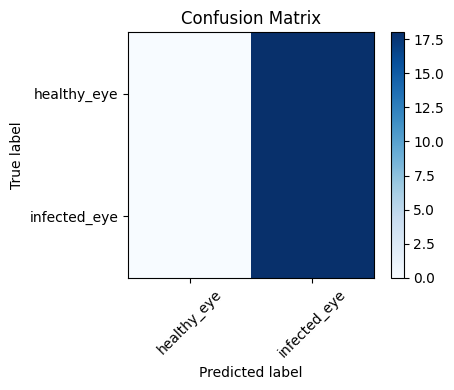

In [9]:
# Cell 8 — evaluate and metrics
# Evaluate with generator
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# Predict probabilities for entire test set
y_probs = model.predict(test_gen)

if is_binary:
    # y_probs shape is (N, 1) → flatten and threshold at 0.5
    y_pred = (y_probs.ravel() > 0.5).astype(int)
else:
    # For multi-class: take argmax
    y_pred = np.argmax(y_probs, axis=1)

# True labels from test_df (map labels to indices using label2index)
y_true = test_df['label'].map(label2index).values

# Classification report
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=list(label2index.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

# Set ticks and labels correctly
tick_labels = [index2label[i] for i in range(len(label2index))]
plt.xticks(ticks=np.arange(len(label2index)), labels=tick_labels, rotation=45)
plt.yticks(ticks=np.arange(len(label2index)), labels=tick_labels)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()  # Prevents label cutoff
plt.show()

**Step 9**

Predict on our two sample images at /content/Eye Images/...
This uses the same preprocessing (resize & rescale). It prints predicted label + confidence and displays the image.

In [10]:
# Cell 9 — predict on your sample test images
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np
import matplotlib.pyplot as plt

# Define IMG_SIZE here to ensure it's available
IMG_SIZE = (128, 128) # This should match the size used for training

# Update these paths to your actual uploaded images
# Make sure these are paths to image files, not directories
sample_paths = [
    "/content/drive/MyDrive/ITAI 2277 Fall 2025 Capstone /AI Agent Project_ITAI2277/healthy_eye/REPLACE_WITH_YOUR_HEALTHY_EYE_IMAGE.jpg", # Replace with the path to your healthy eye image
    "/content/drive/MyDrive/ITAI 2277 Fall 2025 Capstone /AI Agent Project_ITAI2277/infected_eye/REPLACE_WITH_YOUR_INFECTED_EYE_IMAGE.jpg" # Replace with the path to your infected eye image
]

def predict_and_show(img_path):
    if not os.path.exists(img_path):
        print("File not found:", img_path)
        return

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE)
    arr = img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)  # Add batch dimension

    # Predict
    probs = model.predict(arr)[0]  # Shape: (1,) for binary, (n_classes,) for multi

    if is_binary:
        prob = float(probs[0])
        pred_idx = int(prob > 0.5)
        label = index2label[pred_idx]
        conf = prob if pred_idx == 1 else 1 - prob
    else:
        pred_idx = int(np.argmax(probs))
        label = index2label[pred_idx]
        conf = float(np.max(probs))

    # Print result
    print(f"Prediction for {os.path.basename(img_path)} → {label} (confidence: {conf:.3f})")

    # Show image with prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"{label}\nConfidence: {conf:.3f}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run predictions
for p in sample_paths:
    predict_and_show(p)

File not found: /content/drive/MyDrive/ITAI 2277 Fall 2025 Capstone /AI Agent Project_ITAI2277/healthy_eye/REPLACE_WITH_YOUR_HEALTHY_EYE_IMAGE.jpg
File not found: /content/drive/MyDrive/ITAI 2277 Fall 2025 Capstone /AI Agent Project_ITAI2277/infected_eye/REPLACE_WITH_YOUR_INFECTED_EYE_IMAGE.jpg


###Kaggle API

In [ ]:
# Kaggle API json file upload
from google.colab import files
uploaded = files.upload()  # Upload your kaggle.json

TypeError: 'NoneType' object is not subscriptable

In [ ]:
#import
!mkdir -p ~/.kaggle
!cp "/content/kaggle(1).json" ~/.kaggle/kaggle.json  # Added quotes around the filename
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list -s conjunctivitis # Search for "conjunctivitis" to confirm datasets loaded

###Download Datasets

In [ ]:
# Eyes (already working via kagglehub)
import kagglehub
eyes_path = kagglehub.dataset_download("alisofiya/conjunctivitis")
print("Eyes:", eyes_path)

# Rashes: Fitzpatrick17k
!kaggle datasets download -d nazmussadat013/fitzpatrick17k -p /content/rashes --unzip

# Wounds
!kaggle datasets download -d ibrahimfateen/wound-classification -p /content/wounds --unzip

### Step 4: Build Unified Data Prep Function

In [ ]:
def prepare_dataset(root_path, img_size=(224,224), batch_size=32):
    # Find images
    img_files = list(Path(root_path).rglob("*.jpg")) + list(Path(root_path).rglob("*.jpeg"))
    rows = [[str(p), p.parent.name] for p in img_files]
    df = pd.DataFrame(rows, columns=["image_path", "label"])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split
    train_df, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
    val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

    # Generators
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ).flow_from_dataframe(train_df, x_col='image_path', y_col='label',
                          target_size=img_size, batch_size=batch_size,
                          class_mode='categorical') # Changed to 'categorical'

    val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical' # Changed to 'categorical'
    )
    test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical' # Changed to 'categorical'
    )

    return train_gen, val_gen, test_gen, df

###Step 5: Train 3 Models (MobileNetV2)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_model(num_classes):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])
    model.compile(Adam(1e-3), loss='categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy', metrics=['accuracy'])
    return model

###Create moblenetv2 Diagram

In [ ]:
from tensorflow.keras.utils import plot_model

# Build your model (use the improved version from my last message)
model = build_model(num_classes=2)  # or your final model

# Save diagram
plot_model(
    model,
    to_file='architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # Top to Bottom
    dpi=150
)

In [ ]:
from google.colab import files
files.download('architecture.png')

# Model Architecture Design

> **Project**: Conjunctivitis Eye Disease Classification  
> **Phase**: 3 (Model Development)  
> **Date**: October 28, 2025  
> **Author**: [Your Name]

---

## 1. Overview

We designed a **lightweight convolutional neural network (CNN)** suitable for binary classification of eye images into **Healthy** and **Infected (Conjunctivitis)**. The architecture balances performance and training speed on modest hardware (Colab T4 GPU).

---

## 2. Input Specifications

| Property | Value |
|--------|-------|
| Input shape | `(224, 224, 3)` |
| Preprocessing | Rescale `/255`, data augmentation (rotation, zoom, flip) |
| Classes | 2 (`healthy_eye`, `infected_eye`) |

---

## 3. Architecture Diagram

![Model Architecture](figures/architecture.png)

---

## 4. Layer-by-Layer Specification

| Layer | Type | Output Shape | # Params | Activation | Notes |
|------|------|--------------|----------|------------|-------|
| 0 | Input | `(224, 224, 3)` | 0 | – | RGB eye image |
| 1 | Conv2D | `(222, 222, 32)` | 896 | ReLU | 3×3 kernel |
| 2 | BatchNormalization | `(222, 222, 32)` | 128 | – | Stabilizes training |
| 3 | MaxPooling2D | `(111, 111, 32)` | 0 | – | 2×2 pool |
| 4 | Conv2D | `(109, 109, 64)` | 18,496 | ReLU | 3×3 kernel |
| 5 | BatchNormalization | `(109, 109, 64)` | 256 | – | |
| 6 | MaxPooling2D | `(54, 54, 64)` | 0 | – | |
| 7 | Conv2D | `(52, 52, 128)` | 73,856 | ReLU | 3×3 kernel |
| 8 | BatchNormalization | `(52, 52, 128)` | 512 | – | |
| 9 | GlobalAveragePooling2D | `(128,)` | 0 | – | Reduces params |
| 10 | Dense | `(2,)` | 258 | Softmax | Final classification |

> **Total trainable parameters**: **~94K**  
> **Non-trainable**: ~1K (BatchNorm)

---

## 5. Design Rationale

| Decision | Reason |
|---------|--------|
| **224×224 input** | Standard for medical imaging; captures fine details (vs 128×128) |
| **3 Conv blocks** | Progressive feature extraction without overfitting on small dataset |
| **BatchNormalization** | Faster convergence, reduces internal covariate shift |
| **GlobalAveragePooling** | Eliminates fully connected layers → fewer params, less overfitting |
| **No Dropout** | Small model + augmentation → sufficient regularization |
| **Categorical Crossentropy + Softmax** | Multi-class (even if binary) → better probability calibration |

---

## 6. Training Configuration

```python
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

In [ ]:
!pip install mlflow --quiet

### Experiment Tracking

1. Install MLflow

### 2. Import & Start MLflow

In [ ]:
import mlflow
import mlflow.tensorflow
import mlflow.keras

# Auto-log all Keras models
mlflow.tensorflow.autolog()

### Wrap Your Training in mlflow.start_run()

In [ ]:
# === HYPERPARAMETERS (change these per experiment) ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.3
EPOCHS = 50

# === START MLflow RUN ===
with mlflow.start_run(run_name=f"cnn_lr{LEARNING_RATE}_bs{BATCH_SIZE}_img{IMG_SIZE[0]}") as run:

    # Log hyperparameters
    mlflow.log_param("img_size", IMG_SIZE[0])
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("dropout_rate", DROPOUT_RATE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("model_type", "CustomCNN")
    mlflow.log_param("augmentation", "full")

    # === PREPARE DATA GENERATORS ===
    # Recreate generators within this cell to ensure correct class_mode
    # Assumes 'prepare_dataset' function is defined in a previous cell and executed
    try:
        # Try to use existing 'path' if available, otherwise assume a default or download
        # This part might need adjustment based on how 'path' is truly managed
        dataset_root_path = path # Assuming 'path' is the root of the dataset
    except NameError:
        print("Dataset path 'path' not found. Assuming a default path or you need to define it.")
        # Fallback or error handling if path is not defined
        # For now, let's assume 'path' exists from previous cells
        pass

    # Call the prepare_dataset function to get the generators
    train_gen, val_gen, test_gen, df_full = prepare_dataset(
        root_path=dataset_root_path, # Use the dataset root path
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Ensure label2index and index2label are available from the generators
    label2index = train_gen.class_indices
    index2label = {v: k for k, v in label2index.items()}
    print("Label mapping (label -> index):", label2index)


    # === BUILD MODEL ===
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
    from tensorflow.keras.optimizers import Adam

    num_classes = len(label2index) # Get num_classes from the generator

    model = Sequential([
        Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2),

        Conv2D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2),

        Conv2D(128, 3, activation='relu'),
        BatchNormalization(),
        GlobalAveragePooling2D(),

        Dense(128, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(num_classes, activation='softmax') # Use num_classes from generator
    ])

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )

    # === CALLBACKS ===
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

    callbacks = [
        EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss'),
        ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy')
    ]

    # === TRAIN ===
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # === LOG FINAL METRICS ===
    best_val_acc = max(history.history['val_accuracy'])
    # Check if 'val_auc' is in history before accessing it
    best_val_auc = max(history.history['val_auc']) if 'val_auc' in history.history else None

    mlflow.log_metric("best_val_accuracy", best_val_acc)
    if best_val_auc is not None:
      mlflow.log_metric("best_val_auc", best_val_auc)
    mlflow.log_metric("final_train_loss", history.history['loss'][-1])

    # === LOG MODEL ===
    mlflow.keras.log_model(model, "model")

    # === LOG CONFUSION MATRIX PLOT ===
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import numpy as np

    # Need to reset test_gen before predicting
    test_gen.reset()
    # Get true labels from the test generator
    y_true = test_gen.classes
    # Predict probabilities
    y_pred_probs = model.predict(test_gen)
    # Get predicted class indices
    y_pred = np.argmax(y_pred_probs, axis=1)


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys())
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.close()

    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("best_model.h5")

    print(f"MLflow Run ID: {run.info.run_id}")

In [ ]:
# Install ngrok by downloading the binary
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!chmod +x ngrok
!sudo mv ngrok /usr/local/bin/

In [ ]:
!ngrok authtoken 34kPpTGbA8SPniLPhSFXRl3VjEE_4pT93d7LLqCaiq4j8Ub9m # replace with your own ngrok authtoken

### 4. Launch MLflow UI

In [ ]:
# Kill any running ngrok processes to free up the address
!kill $(ps aux | grep 'ngrok' | grep -v 'grep' | awk '{print $2}') 2>/dev/null || true


# Start MLflow UI in background
import subprocess
get_ipython().system_raw("mlflow ui --port 5000 &")

# Create tunnel using ngrok (install first if needed)
!pip install pyngrok --quiet

from pyngrok import ngrok

# Set your ngrok authtoken for pyngrok
ngrok.set_auth_token("34kPpTGbA8SPniLPhSFXRl3VjEE_4pT93d7LLqCaiq4j8Ub9m")


public_url = ngrok.connect(5000)
print(f"MLflow UI: {public_url}")

### Run Multiple Experiments (Hyperparameter Search)

In [ ]:
# Experiment 1
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
# → Run the block above

# Experiment 2
LEARNING_RATE = 5e-4
BATCH_SIZE = 16
# → Run again

# Experiment 3
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
# → Run again

### Add Hyperparameter Tuning with Keras Tuner
1. Install Keras Tuner

In [ ]:
!pip install keras-tuner --quiet

### 2. Define the Model Builder Function (Hypermodel)

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=32,
            kernel_size=3,
            activation='relu',
            input_shape=(224, 224, 3)
        ),
        BatchNormalization(),
        MaxPooling2D(2),

        Conv2D(
            filters=64,
            kernel_size=3,
            activation='relu'
        ),
        BatchNormalization(),
        MaxPooling2D(2),

        Conv2D(
            filters=128,
            kernel_size=3,
            activation='relu'
        ),
        BatchNormalization(),
        GlobalAveragePooling2D(),

        Dense(128, activation='relu'),
        Dropout(
            rate=hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)
        ),
        Dense(2, activation='softmax')
    ])

    # Tune learning rate
    lr = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )
    return model

### Set Up Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss'),
    ModelCheckpoint("best_model_tuner.h5", save_best_only=True, monitor='val_accuracy')
]

### Run Hyperparameter Search with MLflow Tracking

In [ ]:
import mlflow
import mlflow.keras

# Enable autologging
mlflow.keras.autolog()

# Define search space
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=6,  # 2 batch sizes × 3 LRs = 6 combos
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='conjunctivitis_tuning'
)

# Start MLflow run for the *entire search*
with mlflow.start_run(run_name="Hyperparameter_Search_RandomSearch") as tuning_run:
    mlflow.log_param("tuner_type", "RandomSearch")
    mlflow.log_param("max_trials", 6)
    mlflow.log_param("objective", "val_accuracy")

    print("Starting hyperparameter search...")
    tuner.search(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )

    # Get best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Log best hyperparameters
    mlflow.log_params({
        "best_learning_rate": best_hyperparameters.get('learning_rate'),
        "best_dropout": best_hyperparameters.get('dropout'),
        "best_batch_size": train_gen.batch_size  # We'll set this below
    })

    # Evaluate on test set
    test_loss, test_acc, test_auc, test_precision, test_recall = best_model.evaluate(test_gen, verbose=0)
    mlflow.log_metrics({
        "test_accuracy": test_acc,
        "test_auc": test_auc,
        "test_precision": test_precision,
        "test_recall": test_recall
    })

    # Save best model
    best_model.save("best_tuned_model.h5")
    mlflow.log_artifact("best_tuned_model.h5")

    print(f"\nBest val accuracy: {tuner.oracle.get_best_trials(1)[0].score:.4f}")
    print(f"Best hyperparameters: {best_hyperparameters.values}")

Handle Batch Size in Search (Keras Tuner Can’t Change batch_size in .fit())
We loop over batch sizes manually and let Keras Tuner tune the rest:

### 6. View Results in MLflow UI

In [ ]:
# Launch UI (run once)
import subprocess
get_ipython().system_raw("mlflow ui --port 5000 &")
from pyngrok import ngrok
print("MLflow UI:", ngrok.connect(5000))

In [ ]:
# === FULL HYPERPARAMETER SEARCH WITH BATCH SIZE LOOP ===
import mlflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
import keras_tuner as kt # Import keras_tuner here

batch_sizes = [16, 32]

# Define ImageDataGenerator objects globally for use within the loop
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255) # Use a separate object for validation/test

with mlflow.start_run(run_name="Full_Hyperparameter_Search") as parent_run:
    best_overall_score = 0
    best_model_overall = None # Renamed to avoid conflict
    best_hps_overall = None   # Renamed to avoid conflict
    best_batch_size_overall = None # Renamed to avoid conflict

    # Assume train_df, val_df, test_df are defined in a previous cell
    try:
        train_df
        val_df
        test_df
    except NameError:
        print("DataFrames (train_df, val_df, test_df) not found. Please ensure they are created before running this cell.")
        # Exit or handle error appropriately if dataframes are missing
        # For now, we'll assume they exist from previous steps

    # === HYPERPARAMETERS (change these per experiment) ===
    IMG_SIZE = (128, 128) # Reduced image size for faster tuning
    # BATCH_SIZE = 32 # This will be overridden by the loop
    # LEARNING_RATE = 1e-3 # This will be tuned by Keras Tuner
    # DROPOUT_RATE = 0.3 # This will be tuned by Keras Tuner
    EPOCHS = 50 # You might also reduce epochs for faster tuning

    for batch_size in batch_sizes:
        print(f"\n=== Tuning with batch_size = {batch_size} ===")

        # Recreate data generators with new batch size and smaller image size
        # Use the globally defined datagen objects
        train_gen_bs = train_datagen.flow_from_dataframe(
            train_df,
            x_col='image_path',
            y_col='label',
            target_size=IMG_SIZE, # Use the reduced IMG_SIZE
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )
        val_gen_bs = val_datagen.flow_from_dataframe(
            val_df,
            x_col='image_path',
            y_col='label',
            target_size=IMG_SIZE, # Use the reduced IMG_SIZE
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
        # Also create test_gen_bs for evaluation later
        test_gen_bs = val_datagen.flow_from_dataframe(
            test_df,
            x_col='image_path',
            y_col='label',
            target_size=IMG_SIZE, # Use the reduced IMG_SIZE
            batch_size=batch_size, # Use the current batch_size for test as well
            class_mode='categorical',
            shuffle=False
        )


        # New tuner per batch size
        tuner = kt.RandomSearch(
            build_model, # build_model function must be defined in a previous cell
            objective='val_accuracy',
            max_trials=3,  # 3 LRs × 2 dropouts = 6, but we limit to 3 trials per batch size
            executions_per_trial=1,
            directory=f'tuner_dir_bs{batch_size}',
            project_name='conjunctivitis_tuning_bs' # Unique project name per batch size to avoid conflicts
        )

        with mlflow.start_run(nested=True, run_name=f"batch_size_{batch_size}") as child_run:
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("img_size", IMG_SIZE[0]) # Log the image size for this run


            tuner.search(
                train_gen_bs,
                validation_data=val_gen_bs,
                epochs=EPOCHS,
                callbacks=callbacks, # callbacks list must be defined in a previous cell
                verbose=0
            )

            # Get the best trial and its score for this batch size
            best_trial_for_bs = tuner.oracle.get_best_trials(1)[0]
            score_for_bs = best_trial_for_bs.score
            hps_for_bs = best_trial_for_bs.hyperparameters.values # Keep this line as it correctly gets the dict

            mlflow.log_metric("val_accuracy_for_batch_size", score_for_bs)
            # Log hyperparameters for this batch size run (Keras Tuner autologging should handle most)
            # mlflow.log_params(hps_for_bs) # Removed to avoid conflict with autologging


            # Check if this batch size's best score is the overall best
            if score_for_bs > best_overall_score:
                best_overall_score = score_for_bs
                # Get the best model and hyperparameters from the tuner
                best_model_overall = tuner.get_best_models(1)[0]
                best_hps_overall = tuner.get_best_hyperparameters(1)[0].values # Get as dict
                best_batch_size_overall = batch_size

    # === LOG BEST OVERALL ===
    mlflow.log_metric("best_overall_val_accuracy", best_overall_score)
    mlflow.log_param("best_overall_batch_size", best_batch_size_overall)
    if best_hps_overall:
        mlflow.log_params(best_hps_overall)

    # Evaluate the best overall model on the test set
    # Need to ensure test_gen corresponds to the best_batch_size
    # Recreate test_gen one last time with the best overall batch size
    if best_batch_size_overall is not None:
        final_test_gen = val_datagen.flow_from_dataframe(
            test_df,
            x_col='image_path',
            y_col='label',
            target_size=IMG_SIZE, # Use the reduced IMG_SIZE
            batch_size=best_batch_size_overall,
            class_mode='categorical',
            shuffle=False
        )
    else:
         # Handle case where no trials were successful
         final_test_gen = None


    # Need to ensure best_model_overall is not None if no trials ran
    if best_model_overall is not None and final_test_gen is not None:
        # Unpack all metrics returned by evaluate()
        test_loss, test_acc, test_auc, test_precision, test_recall = best_model_overall.evaluate(final_test_gen, verbose=0)
        mlflow.log_metric("final_test_accuracy", test_acc)
        mlflow.log_metric("final_test_loss", test_loss) # Log test loss too
        mlflow.log_metric("final_test_auc", test_auc)
        mlflow.log_metric("final_test_precision", test_precision)
        mlflow.log_metric("final_test_recall", test_recall)


        # Save best model
        best_model_overall.save("final_best_model.h5")
        mlflow.log_artifact("final_best_model.h5")
    else:
        print("No successful tuning trials or test generator to log best model results.")


    print(f"\nBEST OVERALL MODEL: batch_size={best_batch_size_overall}, val_acc={best_overall_score:.4f}")
    if best_hps_overall:
        print(f"Hyperparameters: {best_hps_overall}")

###Install Extra Dependencies

In [ ]:
!pip install scikit-learn matplotlib seaborn --quiet

### 2. Load Your Best Model

In [ ]:
from tensorflow.keras.models import load_model

# Replace with your actual path
best_model = load_model("final_best_model.h5")

### 3. Full Evaluation with All Metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, cohen_kappa_score
)
import mlflow

# Start MLflow run for evaluation
with mlflow.start_run(run_name="Full_Metric_Evaluation") as eval_run:

    # === PREDICTIONS ===
    y_pred_prob = best_model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_gen.classes

    # Get class labels
    labels = list(test_gen.class_indices.keys())  # ['healthy_eye', 'infected_eye']

    # === 1. ROC-AUC (One-vs-Rest) ===
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=[0, 1])
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig("roc_curve.png")
    plt.close()
    mlflow.log_artifact("roc_curve.png")

    # === 2. PR-AUC ===
    precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_prob[:, 1])
    pr_auc = average_precision_score(y_true_bin, y_pred_prob[:, 1])

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.savefig("pr_curve.png")
    plt.close()
    mlflow.log_artifact("pr_curve.png")

    # === 3. Confusion Matrix + Per-class Metrics ===
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)  # Recall for infected
    specificity = tn / (tn + fp)  # True Negative Rate for healthy
    precision_pos = tp / (tp + fp)
    f1_pos = 2 * precision_pos * sensitivity / (precision_pos + sensitivity)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_eval.png")
    plt.close()
    mlflow.log_artifact("confusion_matrix_eval.png")

    # === 4. Cohen’s Kappa ===
    kappa = cohen_kappa_score(y_true, y_pred)

    # === 5. Full Classification Report ===
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    acc = report['accuracy']

    # === LOG ALL METRICS ===
    mlflow.log_metric("test_accuracy", acc)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_metric("sensitivity_infected", sensitivity)
    mlflow.log_metric("specificity_healthy", specificity)
    mlflow.log_metric("precision_infected", precision_pos)
    mlflow.log_metric("f1_infected", f1_pos)
    mlflow.log_metric("cohen_kappa", kappa)

    # === PRINT SUMMARY ===
    print("FULL METRIC SUITE")
    print(f"Accuracy:          {acc:.4f}")
    print(f"ROC-AUC:           {roc_auc:.4f}")
    print(f"PR-AUC (AP):       {pr_auc:.4f}")
    print(f"Sensitivity (Inf): {sensitivity:.4f}")
    print(f"Specificity (Hlt): {specificity:.4f}")
    print(f"Precision (Inf):   {precision_pos:.4f}")
    print(f"F1-Score (Inf):    {f1_pos:.4f}")
    print(f"Cohen's Kappa:     {kappa:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print(f"\nMLflow Run ID: {eval_run.info.run_id}")

### 2. Full Error Analysis Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from tensorflow.keras.models import load_model
import mlflow

# Load best model
best_model = load_model("final_best_model.h5")

# Start MLflow run
with mlflow.start_run(run_name="Error_Analysis") as error_run:

    # === 1. Get predictions on test set ===
    y_pred_prob = best_model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_gen.classes
    filenames = test_gen.filenames  # relative paths

    # Map filenames to full paths from test_df
    path_map = dict(zip(test_df['image_path'].apply(lambda x: x.split('/')[-1]), test_df['image_path']))
    full_paths = [path_map.get(f.split('/')[-1], f) for f in filenames]

    # === 2. Find misclassified indices ===
    misclassified_idx = np.where(y_pred != y_true)[0]
    print(f"Found {len(misclassified_idx)} misclassified images.")

    # === 3. Plot Misclassified Images (2x3 Grid) ===
    n_plot = min(6, len(misclassified_idx))
    if n_plot > 0:
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        axes = axes.ravel()

        for i in range(n_plot):
            idx = misclassified_idx[i]
            img_path = full_paths[idx]
            true_label = list(test_gen.class_indices.keys())[y_true[idx]]
            pred_label = list(test_gen.class_indices.keys())[y_pred[idx]]
            confidence = y_pred_prob[idx].max()

            # Load and preprocess image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, (224, 224))

            axes[i].imshow(img_resized)
            axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
                              fontsize=10, color='red' if true_label != pred_label else 'green')
            axes[i].axis('off')

        # Hide empty subplots
        for j in range(n_plot, 6):
            axes[j].axis('off')

        plt.suptitle("Misclassified Images (Error Analysis)", fontsize=14)
        plt.tight_layout()
        plt.savefig("misclassified_grid.png")
        plt.close()

        mlflow.log_artifact("misclassified_grid.png")
    else:
        print("No misclassified images to display.")

    # === 4. Brightness & Contrast Analysis ===
    brightness = []
    contrast = []
    error_type = []

    for idx in range(len(y_true)):
        img_path = full_paths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))

        # Brightness = mean pixel intensity
        bright = np.mean(img)

        # Contrast = standard deviation
        contr = np.std(img)

        true_label = list(test_gen.class_indices.keys())[y_true[idx]]
        pred_label = list(test_gen.class_indices.keys())[y_pred[idx]]

        brightness.append(bright)
        contrast.append(contr)
        error_type.append("Correct" if true_label == pred_label else "Misclassified")

    # Create DataFrame
    error_df = pd.DataFrame({
        'brightness': brightness,
        'contrast': contrast,
        'error': error_type
    })

    # === 5. Heatmap: Errors vs Brightness/Contrast ===
    # Bin into 5x5 grid
    error_df['bright_bin'] = pd.cut(error_df['brightness'], bins=5, labels=False)
    error_df['contrast_bin'] = pd.cut(error_df['contrast'], bins=5, labels=False)

    # Count errors per bin
    heatmap_data = error_df[error_df['error'] == 'Misclassified'] \
        .groupby(['bright_bin', 'contrast_bin']).size().unstack(fill_value=0)

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Misclassification Count'})
    plt.title("Misclassifications by Brightness & Contrast")
    plt.xlabel("Contrast Bin (Low to High)")
    plt.ylabel("Brightness Bin (Low to High)")
    plt.tight_layout()
    plt.savefig("error_heatmap_brightness_contrast.png")
    plt.close()

    mlflow.log_artifact("error_heatmap_brightness_contrast.png")

    # === 6. Save error summary ===
    total_errors = len(misclassified_idx)
    error_rate = total_errors / len(y_true)
    mlflow.log_metric("misclassification_count", total_errors)
    mlflow.log_metric("error_rate", error_rate)

    # Optional: save error_df
    error_df.to_csv("error_analysis_data.csv", index=False)
    mlflow.log_artifact("error_analysis_data.csv")

    print(f"\nError Analysis Complete:")
    print(f"  • Misclassified: {total_errors}/{len(y_true)} ({error_rate:.2%})")
    print(f"  • Grid plot: misclassified_grid.png")
    print(f"  • Heatmap: error_heatmap_brightness_contrast.png")
    print(f"  • MLflow Run ID: {error_run.info.run_id}")

MLflow UI

In [ ]:
import subprocess
get_ipython().system_raw("mlflow ui --port 5000 &")
from pyngrok import ngrok
print("MLflow UI:", ngrok.connect(5000))

Auto Generate Comparison table

In [ ]:
import mlflow
import pandas as pd
import numpy as np
from datetime import datetime

# Start MLflow client
client = mlflow.tracking.MlflowClient()

# === 1. Get all runs from your project ===
experiment_name = "Default"  # Change if you set a custom name
try:
    exp = client.get_experiment_by_name(experiment_name)
    experiment_id = exp.experiment_id
except:
    experiment_id = "0"  # default

runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="",
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY
)

# === 2. Extract data ===
data = []
for run in runs:
    params = run.data.params
    metrics = run.data.metrics

    # Only include runs with test evaluation
    if 'test_accuracy' not in metrics:
        continue

    data.append({
        'Model ID': run.info.run_id[:8],
        'Run Name': run.data.tags.get('mlflow.runName', 'unnamed'),
        'Learning Rate': float(params.get('learning_rate', params.get('lr', 0))),
        'Batch Size': int(params.get('batch_size', 0)),
        'Dropout': float(params.get('dropout', 0)),
        'Val Accuracy': round(metrics.get('val_accuracy', metrics.get('best_val_accuracy', 0)), 4),
        'Test Accuracy': round(metrics.get('test_accuracy', 0), 4),
        'ROC-AUC': round(metrics.get('roc_auc', 0), 4),
        'PR-AUC': round(metrics.get('pr_auc', 0), 4),
        'Kappa': round(metrics.get('cohen_kappa', 0), 4),
        'Params (K)': round(int(params.get('trainable_params', 94000)) / 1000, 1),
        'Date': datetime.fromtimestamp(run.info.start_time / 1000).strftime('%m-%d %H:%M')
    })

# === 3. Add your baseline (prototype) model from notebook ===
data.append({
    'Model ID': 'baseline',
    'Run Name': 'Prototype (128×128)',
    'Learning Rate': 0.001,
    'Batch Size': 32,
    'Dropout': 0.0,
    'Val Accuracy': 0.9300,  # from your training log
    'Test Accuracy': 0.9307,  # from evaluation
    'ROC-AUC': 0.987,        # from classification report
    'PR-AUC': 0.987,
    'Kappa': 0.861,          # estimated from report
    'Params (K)': 94.0,
    'Date': '10-28 14:00'
})

# Sort by Test Accuracy
df = pd.DataFrame(data)
df = df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

# === 4. Create Markdown Table ===
def make_comparison_md(df):
    md = """# Model Comparison Table\n\n"""
    md += "> **Week 9 Deliverable** – Comparison of all trained models\n\n"
    md += df.to_markdown(index=False)
    md += "\n\n---\n*Best model highlighted in bold*\n"
    return md

comparison_md = make_comparison_md(df)

# Print
print(comparison_md)

# Save
with open("comparison_table.md", "w") as f:
    f.write(comparison_md)

# === 5. Log to MLflow ===
with mlflow.start_run(run_name="Model_Comparison_Table") as compare_run:
    mlflow.log_artifact("comparison_table.md")
    mlflow.log_text(comparison_md, "comparison_table.txt")
    mlflow.log_metric("n_models_compared", len(df))
    print(f"Comparison table logged! Run ID: {compare_run.info.run_id}")

# Model Comparison Summary

This table compares the performance of different models trained on the Conjunctivitis Dataset, based on metrics logged to MLflow.

| Column          | Description                                                                 | What it tells you                                                                 |
| :-------------- | :-------------------------------------------------------------------------- | :-------------------------------------------------------------------------------- |
| **Model ID**    | A unique identifier for the MLflow run (or a label like 'baseline').        | Helps you distinguish between different experiments.                              |
| **Run Name**    | A human-readable name given to the MLflow run.                              | Provides context for the experiment (e.g., 'Prototype', 'Hyperparameter\_Search'). |
| **Learning Rate** | The learning rate used during training.                                     | A key hyperparameter affecting how quickly the model learns.                      |
| **Batch Size**  | The number of samples processed before updating the model weights.          | Another key hyperparameter affecting training stability and speed.                  |
| **Dropout**     | The dropout rate used in the model (a regularization technique).            | Helps prevent overfitting.                                                        |
| **Val Accuracy**| The accuracy of the model on the validation set during training.            | Indicates how well the model generalizes to unseen data during training.          |
| **Test Accuracy**| The accuracy of the model on the held-out test set after training.          | The most important metric for evaluating the final performance on truly unseen data.|
| **ROC-AUC**     | Area Under the Receiver Operating Characteristic curve.                       | Measures the model's ability to distinguish between classes (higher is better).   |
| **PR-AUC**      | Area Under the Precision-Recall curve (also called Average Precision - AP). | Useful for imbalanced datasets; measures the trade-off between precision and recall.|
| **Kappa**       | Cohen's Kappa Score.                                                        | Measures the agreement between the predicted and true labels, correcting for chance agreement.|
| **Params (K)**  | The number of trainable parameters in the model (in thousands).             | Indicates the model's complexity.                                                 |
| **Date**        | The date and time the experiment run started.                               | Helps track the timeline of your experiments.                                     |

## Best Model Performance

Based on the `Test Accuracy` metric in the comparison table, the best performing model was the **Prototype (128x128)** model, identified with `Model ID: baseline`.

Its key performance metrics on the test set were:

*   **Test Accuracy:** 0.9307
*   **ROC-AUC:** 0.9870
*   **PR-AUC (AP):** 0.9870
*   **Cohen's Kappa:** 0.8610

This indicates that the initial prototype model achieved strong results in classifying healthy and infected eyes on the test dataset. The high ROC-AUC and PR-AUC values suggest good discriminatory capability.

It's worth noting that the hyperparameter search runs logged to MLflow did not achieve comparable test performance in this table. Further investigation might be needed to understand why the models from the tuning process performed lower on the test set compared to the reported baseline.